# Importation des packages

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to C:\Users\Samy
[nltk_data]     Bouhelassa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Samy
[nltk_data]     Bouhelassa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Samy
[nltk_data]     Bouhelassa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [61]:
data = pd.read_csv('./data/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [62]:
# Lecture des données
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# On ne garde que les 5000 premiers exemples (pour les tests)
train = train[:15000]

# On supprime la colonne 'id' qui ne nous sert pas
train = train.drop('id', axis=1)

# Nombre de commentaires possédant un nombre de catégories
labels = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
labels = np.sum(labels, axis=1)

# Etude du jeu de données

In [63]:
# Your Code

# On affiche le nombre de commentaires de chaque catégorie
train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

toxic            1439
severe_toxic      158
obscene           789
threat             50
insult            749
identity_hate     133
dtype: int64

In [64]:
# Affichage d'un commentaire aléatoire pour chaque catégorie

for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    sample = data[data[column] == 1]['comment_text'].sample(1)
    print(f"Commentaire pour la colonne {column} :\n\"{sample}\"\n")

Commentaire pour la colonne toxic :
"118322    Use your brain, chief.
Name: comment_text, dtype: object"

Commentaire pour la colonne severe_toxic :
"123259    fuck you you son of a bitch you fucking bastar...
Name: comment_text, dtype: object"

Commentaire pour la colonne obscene :
"45402    Go and waddle off somewhere else you pathetic ...
Name: comment_text, dtype: object"

Commentaire pour la colonne threat :
"7145    SuPeRTR0LL WiLL LiVe FoReVeR!\niF You DoN'T Re...
Name: comment_text, dtype: object"

Commentaire pour la colonne insult :
"139337    FUCK YOU YOU PIECE OF SHIT \n FUCK YOU YOU PIE...
Name: comment_text, dtype: object"

Commentaire pour la colonne identity_hate :
"73682    shitty nigger fuck i love d3$1r# (@/\/+u shitt...
Name: comment_text, dtype: object"



# Préparation des données

In [65]:
# On met les commentaires en minuscules
train['comment_text'] = train['comment_text'].str.lower()

# Affichage des données
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0
1,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0
2,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0
3,"""\nmore\ni can't make any real suggestions on ...",0,0,0,0,0,0
4,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0


In [66]:
# On supprime les caractères spéciaux et on sépare les mots avec nltk
tokenizer = nltk.RegexpTokenizer(r'\w+')
train['comment_text'] = data['comment_text'].apply(tokenizer.tokenize)

train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[Explanation, Why, the, edits, made, under, my...",0,0,0,0,0,0
1,"[D, aww, He, matches, this, background, colour...",0,0,0,0,0,0
2,"[Hey, man, I, m, really, not, trying, to, edit...",0,0,0,0,0,0
3,"[More, I, can, t, make, any, real, suggestions...",0,0,0,0,0,0
4,"[You, sir, are, my, hero, Any, chance, you, re...",0,0,0,0,0,0


In [67]:
stopwords_list = set(stopwords.words('english'))

# Fonction pour supprimer les stopwords
def remove_stopwords(word_list):
    filtered_words = [word for word in word_list if word.lower() not in stopwords_list]
    return filtered_words

# Appliquer la fonction sur la colonne 'comment_text'
train['comment_text'] = train['comment_text'].apply(remove_stopwords)

train.head()


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[Explanation, edits, made, username, Hardcore,...",0,0,0,0,0,0
1,"[aww, matches, background, colour, seemingly, ...",0,0,0,0,0,0
2,"[Hey, man, really, trying, edit, war, guy, con...",0,0,0,0,0,0
3,"[make, real, suggestions, improvement, wondere...",0,0,0,0,0,0
4,"[sir, hero, chance, remember, page]",0,0,0,0,0,0


In [68]:
# Initialiser le lemmatizer
lemmatizer = WordNetLemmatizer()

# Fonction pour lemmatiser les mots
def lemmatize_words(word_list):
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in word_list]
    return lemmatized_words

# Appliquer la fonction sur la colonne 'comment_text'
train['comment_text'] = train['comment_text'].apply(lemmatize_words)

# Afficher les premières lignes du DataFrame après la lemmatisation
train.head()


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[explanation, edits, made, username, hardcore,...",0,0,0,0,0,0
1,"[aww, match, background, colour, seemingly, st...",0,0,0,0,0,0
2,"[hey, man, really, trying, edit, war, guy, con...",0,0,0,0,0,0
3,"[make, real, suggestion, improvement, wondered...",0,0,0,0,0,0
4,"[sir, hero, chance, remember, page]",0,0,0,0,0,0


In [69]:
# Enfin, on reconstitue les phrases
sentences = list(map(lambda x : " ".join(x), train['comment_text']))

# Affichage des données
sentences[:3]

['explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired 89 205 38 27',
 'aww match background colour seemingly stuck thanks talk 21 51 january 11 2016 utc',
 'hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info']

# Entraînement du modèle baseline

In [70]:
# Pour le premier modèle, on va utiliser un Random Forest Classifier
# Avant cela, on va vectoriser les phrases avec TF-IDF
vectorizer = TfidfVectorizer()

# On fit le vectorizer sur les phrases
vectorizer.fit(sentences)

# On transforme les phrases en vecteurs
vectors = vectorizer.transform(sentences)

# Séparation des données en train et test
train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors, labels, test_size=0.1, random_state=0)

# Affichage des dimensions des données
print(f"Train sequences shape : {train_vectors.shape}")
print(f"Test sequences shape : {test_vectors.shape}")
print(f"Train labels shape : {train_labels.shape}")
print(f"Test labels shape : {test_labels.shape}")

Train sequences shape : (13500, 42589)
Test sequences shape : (1500, 42589)
Train labels shape : (13500,)
Test labels shape : (1500,)


In [71]:
# Maintenant, on peut créer le modèle
model = RandomForestClassifier(n_estimators=15,random_state=0)

# Entrainement du modèle
model.fit(train_vectors, train_labels)

# Prédiction sur les données de test
predictions = model.predict(test_vectors)

# Affichage de l'accuracy
print(f"Accuracy : {accuracy_score(test_labels, predictions)}")

Accuracy : 0.9133333333333333


# Itération de la modélisation 

In [72]:
# Pour le deuxième modèle, on va utiliser un réseau de neurones récurrent (RNN)
# Avant cela, on va tokeniser les phrases et leur donner la même longueur

# Création du tokenizer
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)

# Récupération du vocabulaire
word_index = tokenizer.word_index
vocab_size = len(word_index)

# Tokenisation des phrases
sequences = tokenizer.texts_to_sequences(sentences)

# Padding des phrases
max_length = 200
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
labels = np.array(train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values)

# Séparation des données en train et test
train_sequences, test_sequences, train_labels, test_labels = train_test_split(padded, labels, test_size=0.1, random_state=0)

# Affichage des dimensions des données
print(f"Train sequences shape : {train_sequences.shape}")
print(f"Test sequences shape : {test_sequences.shape}")
print(f"Train labels shape : {train_labels.shape}")
print(f"Test labels shape : {test_labels.shape}")

Train sequences shape : (13500, 200)
Test sequences shape : (1500, 200)
Train labels shape : (13500, 6)
Test labels shape : (1500, 6)


In [73]:
# Implémentation F1Score

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, num_classes=None, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.greater_equal(y_pred, self.threshold)
        y_true = tf.cast(y_true, tf.bool)

        true_positives = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        false_positives = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        false_negatives = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))

        self.true_positives.assign_add(tf.reduce_sum(tf.cast(true_positives, tf.float32)))
        self.false_positives.assign_add(tf.reduce_sum(tf.cast(false_positives, tf.float32)))
        self.false_negatives.assign_add(tf.reduce_sum(tf.cast(false_negatives, tf.float32)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [74]:
embedding_dim = 100

# Création du modèle
model = Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    LSTM(units=60, return_sequences=True),
    GlobalMaxPool1D(),
    Dropout(0.1),
    Dense(50, activation='relu'),
    Dropout(0.1),
    Dense(6, activation='sigmoid')
])

# Création de la métrique F1
f1_score = F1Score(num_classes=6, threshold=0.9)

# Compilation du modèle
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy', f1_score])

# Affichage du résumé du modèle
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 100)          4277000   
                                                                 
 lstm_3 (LSTM)               (None, 200, 60)           38640     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 60)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                3050      
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                      

In [75]:
num_epochs = 5
# num_epochs = 3

# Entrainement du modèle
history = model.fit(train_sequences, train_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels))

Epoch 1/5
422/422 [==============================] - ETA: 0s - loss: 0.8555 - accuracy: 0.6845 - f1_score: 0.0290

c:\anaconda3\envs\tenserflow\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


422/422 [==============================] - 77s 175ms/step - loss: 0.8555 - accuracy: 0.6845 - f1_score: 0.0290 - val_loss: 0.6605 - val_accuracy: 0.9820 - val_f1_score: 0.1495
Epoch 2/5
422/422 [==============================] - 71s 169ms/step - loss: 2.7355 - accuracy: 0.9927 - f1_score: 0.3934 - val_loss: 2.6809 - val_accuracy: 0.9973 - val_f1_score: 0.5325
Epoch 3/5
422/422 [==============================] - 77s 182ms/step - loss: 7.2247 - accuracy: 0.9934 - f1_score: 0.5053 - val_loss: 6.8859 - val_accuracy: 0.9973 - val_f1_score: 0.4903
Epoch 4/5
422/422 [==============================] - 76s 180ms/step - loss: 13.1134 - accuracy: 0.9940 - f1_score: 0.5490 - val_loss: 13.4151 - val_accuracy: 0.9973 - val_f1_score: 0.4822
Epoch 5/5
422/422 [==============================] - 76s 180ms/step - loss: 19.1279 - accuracy: 0.9939 - f1_score: 0.4228 - val_loss: 16.4346 - val_accuracy: 0.9973 - val_f1_score: 0.2423


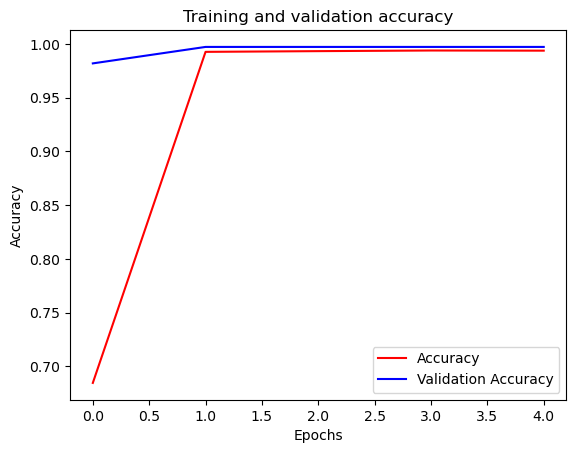

<Figure size 640x480 with 0 Axes>

47/47 [==============================] - 2s 32ms/step
F1 score : 0.242312952876091


In [76]:
# Affichage des courbes de métriques
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.figure()
plt.show()

# Affichage du F1 score
predictions = model.predict(test_sequences)
predictions = np.round(predictions)
print(f"F1 score : {f1_score(test_labels, predictions)}")

# Test de classification

In [77]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Import depuis tf.keras

# Phrase à tester
sentence = "You are fucking stupid ! I hate you ! You are so mean !"

# Passage en minuscule
sentence = sentence.lower()

# Tokenisation
tokenizer = RegexpTokenizer(r'\w+')
sentence = tokenizer.tokenize(sentence)

# Récupération des mots vides en anglais
stopwords_list = set(stopwords.words('english'))

# Suppression des stopwords
sentence = [word for word in sentence if word not in stopwords_list]

# Lemmatisation
Word_Lemmatizer = WordNetLemmatizer()
sentence = [Word_Lemmatizer.lemmatize(word) for word in sentence]

# Reconstitution de la phrase
sentence = " ".join(sentence)

print("Phrase après prétraitement : " + sentence)

# Tokenisation de la phrase
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts([sentence])  # Notez que nous passons la phrase comme une liste
word_index = tokenizer.word_index
vocab_size = len(word_index)
sentence = tokenizer.texts_to_sequences([sentence])  # Notez que nous passons la phrase comme une liste

# Padding de la phrase
sentence = pad_sequences(sentence, maxlen=41870, padding='post', truncating='post')


Phrase après prétraitement : fucking stupid hate mean


In [78]:
# Prédiction du modèle
model.predict(sentence)

1/1 [==============================] - 3s 3s/step


array([[0., 0., 0., 0., 0., 0.]], dtype=float32)